<a href="https://colab.research.google.com/github/DonnaVakalis/Urban.dat/blob/master/maml_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capstone Project: City Features

 

## Table of Contents
- [Introduction](#intro)
- [Part I - SETUP the data](#partone)
- [Part II - MODEL and Visualize Results](#parttwo)
- [Part III - FUTURE work (Mutual Info)](#partthree)




<a id='intro'></a>
### Introduction

This notebook gathers, assesses then analyses some data from a global dataset of cities from here:
Nangini, C., Peregon, A., Ciais, P. et al. A global dataset of CO2 emissions and ancillary data related to emissions for 343 cities. Sci Data 6, 180280 (2019). https://doi.org/10.1038/sdata.2018.280


Initially the data exploration and analysis are part of coursework completed for the Mothers and Machine Learning Course offered in Winter 2022 (online) by the Vector Institute. 

In this notebook I explore how 'measures' of global cities relate to each other, and then after doing some feature selection, use the remaining features to pose a question 'which cities are most similar to one another' and analyse the implications of the matches. 
 
I build two models using KNN used for matching:  one including features that have enough 'coverage' across most cities; and one after reducing the features to those will less inter-feature correlation. 
 
Note:
Originally I had in mind using this dataset for a different question.  I've heard that urban density is more environmentally responsible: among these cities what is the relationship between density and per capita emissions?
However there is too much missing data: emissions reported but energy is not... i.e., the emissions could be driven by fuel source (same amount of energy, but more/less emissions). 

 

Along the way, through comments I will provide insight into the methods I chose and why I chose them. I will also provide a connection between my three questions and how the data answers them...
__________

resources https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html

<a id='partone'></a>
# Part I - Setup

## Import libraries, mount drive and load raw dataset [dat01]

In [1]:
# import libraries

%pip install ennemi

import os
from google.colab import drive, files

import pandas as pd # for everything! 
import numpy as np # diddo
import statsmodels.formula.api as smf # for writing models like in R :)


# for mutual information calcs and feature selection:
from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi
from ennemi import estimate_mi, pairwise_mi, pairwise_corr
from sklearn.ensemble import RandomForestRegressor # for feature selection
from sklearn.neighbors import NearestNeighbors

from math import sqrt # for euclidean distance calcs

import matplotlib.pyplot as plt # for visualizing answers
import seaborn as sns # for heatmap viz

%matplotlib inline

     |████████████████████████████████| 38.1 MB 2.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Data source: https://doi.pangaea.de/10.1594/PANGAEA.884141
# Downloaded this file manually 

# Point to the folder for this project 
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/Colab Notebooks/MaML/" 


# Load data into Pandas

dat = pd.read_excel(
  DATA_PATH+'D_FINAL.xlsx',
  engine='openpyxl'
  #index_col=False,
  #dtype=COLUMN_NAMES
)

Mounted at /content/gdrive


In [3]:
pd.set_option('display.max_columns', None)
dat.sample(1)

,Unnamed: 0,City name,City name (CDP),City name (carbonn),City name (PKU),City name (GEA),City name (UITP),City name (WB),Definition (CDP),Definition (carbonn),Definition (WB),Study year (WB),Reporting year (CDP),Scope-1 GHG emissions [tCO2 or tCO2-eq],Scope-1 source dataset,Scope-1 GHG emissions units,Year of emission,Emissions protocol,Gases included (CDP),Methodology details (CDP),Increase/Decrease from last year (CDP),Reason for increase/decrease in emissions (CDP),Scope-2 (CDP) [tCO2-eq],Total emissions (CDP) [tCO2-eq],CDP2016 data edited (CDP),Emissions Quality Flag (CDP),S1 lower bound [tCO2] (CDP),S1 upper bound [tCO2] (CDP),S1 mean (CDP) [tCO2],TOT lower bound [tCO2] (CDP),TOT upper bound [tCO2] (CDP),TOT mean (CDP) [tCO2],Scope fraction (CDP),CO2 emissions per capita (PKU) [tCO2/capita],City location (CDP) [degrees],Latitude (others) [degrees],Longitude (others) [degrees],Coordinate source (others),Country,Region,Population (CDP),Population year (CDP),Population (carbonn),Population year (carbonn),Urban population (PKU),Population (GEA),Population (UITP),Population (WB),Population year (WB),Population (others),Population year (others),Population source (others),Population 1950 (WB),Population 1990 (WB),Population 2010 (WB),Population growth rate 1950-2010 (WB) [people/60years],Population growth rate 1990-2010 (WB) [people/20years],Ancillary from GEA+,City area (CDP) [km2],City area (GEA) [km2],City area (WB) [km2],Built-up area (PKU) [km2],City area (others) [km2],City area source year (others),City area source (others),Population density (GEA) [people/km2],Population density (UITP) [people/km2],Population density (WB) [people/km2],Population/sqrt(area) (GEA) [people/km],Population/sqrt(area) (WB) [people/km],Average altitude [m],Average annual temperature (CDP) [degrees Celsius],Weather station ID (GEA+),CDD 23C (GEA+) [degrees C × days],HDD 15.5C (GEA+) [degrees C × days],HDD 15.5C (clim) [degrees C × days],CDD 23C (clim) [degrees C × days],GDP (CDP) [multiple units],GDP unit (CDP),GDP year (CDP),GDP source (CDP),GDP (carbonn) [multiple units],nGDP (carbonn) [multiple units],GDP unit (carbonn),GDP year (carbonn),GDP (PKU) [10000 RMB],Income per capita (PKU) [RMB/capita],GDP-PPP (others) [$BN],GDP-PPP/capita (others) [USD/capita],GDP-PPP source (others),GDP-PPP year (others),nGDP (others) [$BN],nGDP/capita (others) [USD/capita],nGDP source (others),nGDP year (others),GDP-PPP/capita (GEA) [USD/year],GDP-PPP/capita (UITP) [USD/year],GDP-PPP/capita (WB) [USD/year],Total final consumption per capita (GEA) [GJ/capita/yr],Energy per capita CO2 (WB) [tCO2-eq/capita/yr],Diesel price (GEA+) [USD/liter],Gasoline price (GEA+) [USD/liter],Center of commerce index (GEA+) [dimensionless],Household size (GEA+) [people/household],Household size year (GEA+),Household source (GEA+),Household size comment (GEA+),Urbanization ratio (GEA+) [percent],Water bounded (GEA+),Other bounded (GEA+),Mean one-way travel time (others) [minutes],Mean one-way travel time year (others),Mean one-way travel time source (others),Diesel price 2014 (others) [USD/liter],Gasoline price 2014 (others) [USD/liter],Household size (others) [people/household],Household size year (others),Household size source (others),Household size comment (others),Congestion rank (INRIX) [dimensionless],Peak hours spent in congestion (INRIX) [hours],INRIX congestion index (INRIX) [dimensionless],Average congestion rate (INRIX) [percent],Congestion rank (TomTom) [dimensionless],Congestion level (TomTom) [× 100 percent],Congestion change (TomTom) [× 100 percent],Morning peak (TomTom) [percent],Evening peak (TomTom) [percent],Economy (IESE) [dimensionless],Environment (IESE) [dimensionless],Governance (IESE) [dimensionless],Human capital (IESE) [dimensionless],International impact (IESE) [dimensionless],Mobility and transportation (IESE) [dimensionless],Public management (IESE) [dimensionless],Social cohesion (IESE) [dimensionless],Technology (IESE) [dimensionless],Urban planning 

In [4]:
# 1. Zero-in on the columns of interest:

print('There are', dat.shape[1], 'columns in the original dataframe.')

# get copy-and-pastable list of data names...
# print(dat.columns.tolist())
cols_keep = ['City name', 'Reporting year (CDP)', 'Scope-1 GHG emissions [tCO2 or tCO2-eq]', 'Scope-1 GHG emissions units', 'Year of emission', 'Gases included (CDP)', 'Increase/Decrease from last year (CDP)', 'Scope-2 (CDP) [tCO2-eq]', 
             'Total emissions (CDP) [tCO2-eq]', 'S1 lower bound [tCO2] (CDP)', 'S1 upper bound [tCO2] (CDP)', 'S1 mean (CDP) [tCO2]', 'TOT lower bound [tCO2] (CDP)', 'TOT upper bound [tCO2] (CDP)', 'TOT mean (CDP) [tCO2]', 
             'CO2 emissions per capita (PKU) [tCO2/capita]', 
             'City location (CDP) [degrees]', 'Latitude (others) [degrees]', 'Longitude (others) [degrees]',  'Country', 'Region', 
             'Population (CDP)', 'Population year (CDP)', 'Population (carbonn)', 'Population year (carbonn)', 'Urban population (PKU)', 'Population (GEA)', 'Population (UITP)', 'Population (WB)', 
             #'Population year (WB)', 'Population (others)', 'Population year (others)', 'Population 1950 (WB)', 'Population 1990 (WB)', 'Population 2010 (WB)', 
             'Population growth rate 1950-2010 (WB) [people/60years]', 'Population growth rate 1990-2010 (WB) [people/20years]', 
             'City area (CDP) [km2]', 'City area (GEA) [km2]', 'City area (WB) [km2]', 'Built-up area (PKU) [km2]', 'City area (others) [km2]', 
             #'City area source year (others)', 'City area source (others)', 
             'Population density (GEA) [people/km2]', 'Population density (UITP) [people/km2]', 'Population density (WB) [people/km2]', 'Population/sqrt(area) (GEA) [people/km]', 'Population/sqrt(area) (WB) [people/km]', 
             'Average altitude [m]', 'Average annual temperature (CDP) [degrees Celsius]', 'Weather station ID (GEA+)', 'CDD 23C (GEA+) [degrees C × days]', 'HDD 15.5C (GEA+) [degrees C × days]', 'HDD 15.5C (clim) [degrees C × days]', 'CDD 23C (clim) [degrees C × days]', 
             'GDP (CDP) [multiple units]', 'GDP unit (CDP)', 'GDP (carbonn) [multiple units]', 'nGDP (carbonn) [multiple units]', 'GDP unit (carbonn)', 'GDP (PKU) [10000 RMB]', 
             'Income per capita (PKU) [RMB/capita]', 'GDP-PPP (others) [$BN]', 'GDP-PPP/capita (others) [USD/capita]', 'GDP-PPP year (others)', 'nGDP (others) [$BN]', 'nGDP/capita (others) [USD/capita]', 'nGDP year (others)', 'GDP-PPP/capita (GEA) [USD/year]', 'GDP-PPP/capita (UITP) [USD/year]', 'GDP-PPP/capita (WB) [USD/year]', 
             'Total final consumption per capita (GEA) [GJ/capita/yr]', 'Energy per capita CO2 (WB) [tCO2-eq/capita/yr]', 
             'Diesel price (GEA+) [USD/liter]', 'Gasoline price (GEA+) [USD/liter]', 'Diesel price 2014 (others) [USD/liter]', 'Gasoline price 2014 (others) [USD/liter]',
             'Center of commerce index (GEA+) [dimensionless]', 
             'Household size (GEA+) [people/household]', 'Household size (others) [people/household]', 
             'Urbanization ratio (GEA+) [percent]', 
             'Water bounded (GEA+)', 'Other bounded (GEA+)', 
             'Mean one-way travel time (others) [minutes]', #Mean one-way travel time to travel to work for city citizen
             'Congestion rank (INRIX) [dimensionless]', 'Peak hours spent in congestion (INRIX) [hours]', 'INRIX congestion index (INRIX) [dimensionless]', 'Average congestion rate (INRIX) [percent]', 'Congestion rank (TomTom) [dimensionless]', 'Congestion level (TomTom) [× 100 percent]', 'Congestion change (TomTom) [× 100 percent]', 'Morning peak (TomTom) [percent]', 'Evening peak (TomTom) [percent]', 
             'Economy (IESE) [dimensionless]', 
             'Environment (IESE) [dimensionless]', 
             'Governance (IESE) [dimensionless]', 
             'Human capital (IESE) [dimensionless]', 
             'International impact (IESE) [dimensionless]', 
             'Mobility and transportation (IESE) [dimensionless]', 
             'Public management (IESE) [dimensionless]', 
             'Social cohesion (IESE) [dimensionless]', 
             'Technology (IESE) [dimensionless]', 
             'Urban planning (IESE) [dimensionless]', 
             'CIMI (IESE) [dimensionless]', 'CIMI ranking (IESE) [dimensionless]', 'CIMI performance (IESE) [dimensionless]', 
             'Urban area name (UEX)', 'Low BUA - 1990 (UEX) [km2]', 'Low BUA - 2000 (UEX) [km2]', 'Low BUA - 2014 (UEX) [km2]', 'High BUA - 1990 (UEX) [km2]', 'High BUA - 2000 (UEX) [km2]', 'High BUA - 2014 (UEX) [km2]', 'Low BUA % - 1990 (UEX) [percent]', 'Low BUA % - 2000 (UEX) [percent]', 'Low BUA % - 2014 (UEX) [percent]', 'High BUA % - 1990 (UEX) [percent]', 'High BUA % - 2000 (UEX) [percent]', 'High BUA % - 2014 (UEX) [percent]', 'Low BUA population density - 1990 (UEX) [people/km2]', 'High BUA population density - 1990 (UEX) [people/km2]', 'Low BUA population density - 2000 (UEX) [people/km2]', 'High BUA population density - 2000 (UEX) [people/km2]', 'Low BUA population density - 2014 (UEX) [people/km2]', 'High BUA population density - 2014 (UEX) [people/km2]', # Urban area expansion in units of percentage of total built-up area (BUA) for low and high BUAs reflects the increase in the built environment 
             'Exports (others) [m3]', 'Production (others) [m3]', 'Natgas Export/Production ratio (others)', #Domestic natural gas export/production 
             'CH4_waste/capita (others) [tCH4/capita]', 'CH4_waste+natgas/capita (others) [tCH4/capita]', 'Corrected CH4_(waste+natgas)/capita (others) [tCH4/capita]']

            

print('Keep', dat[cols_keep].shape[1], 'columns of interest to begin with...')

#rename key outcome variables
dat01 = dat[cols_keep].rename(columns={'City name':'city',
                                       'Total final consumption per capita (GEA) [GJ/capita/yr]':'nrg_pp',
                                       'Scope-1 GHG emissions [tCO2 or tCO2-eq]':'co2_tot'})

# Total Co2 is outcome of interest: drop 36 rows that do not report ()
dat01.dropna(axis=0, subset=['co2_tot'], inplace=True)
len(dat01[dat01.co2_tot.isnull()])

# Add a 'feature' to differentiate between Canadian and non-Canadian cities
dat01['is_cad'] = np.where(dat01['Country'] == 'Canada', 1, 0)  


There are 180 columns in the original dataframe.
Keep 124 columns of interest to begin with...


## First quick n' dirty look at the data [dat02]

There are 11 Canadian cities, and  296 other cities in the data set.


,city,nrg_pp,co2_tot,Energy per capita CO2 (WB) [tCO2-eq/capita/yr]
7,"Ajax, ON",NaN,6354.0,NaN
53,Calgary,NaN,10448332.0,17.3
84,Edmonton,NaN,10215142.0,NaN
110,"Hamilton, ON",NaN,6304593.0,NaN
176,"London, ON",NaN,2771000.0,NaN
191,Montreal,NaN,13634331.0,NaN
209,North Vancouver,NaN,182896.0,NaN
294,Toronto,162.915756,16151019.0,9.8
305,Vancouver,NaN,2389748.0,NaN
314,"Windsor, ON",NaN,2475703.0,NaN


Mean Canadian emissions per person: 6340597 tonnes C02e per capita
Mean non-Canadian energy per person: 8541075 tonnes C02e per capita


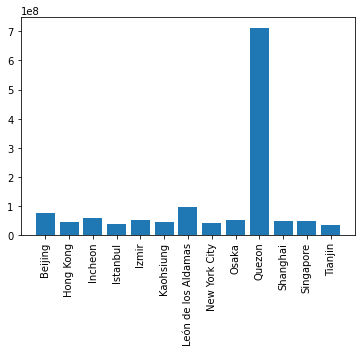

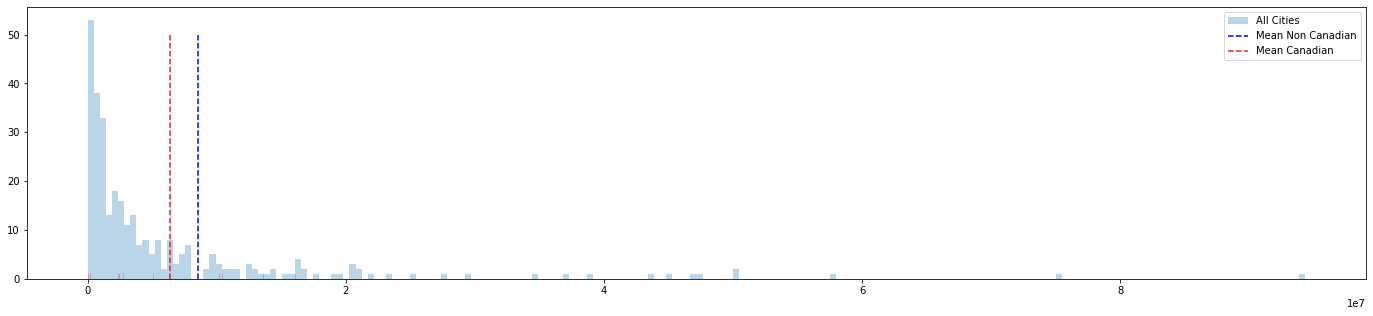

In [5]:
# Quick n' dirty exploration of where Canadian cities stand

dat02 = dat01.copy()
print('There are',  dat02.is_cad.value_counts()[1], 'Canadian cities, and ',dat02.is_cad.value_counts()[0] , 'other cities in the data set.') 
#Unfortunately, not enough energy data to ask questions that require knowing this (i.e., total emissions might depend on fuel source, but impossible to know without controlling for underlying energy consumption.)
display(dat02[dat02.is_cad==1][['city','nrg_pp','co2_tot','Energy per capita CO2 (WB) [tCO2-eq/capita/yr]']])

mu_co2_cad = dat02.query("is_cad==1")['co2_tot'].mean()
print('Mean Canadian emissions per person:', round(mu_co2_cad), 'tonnes C02e per capita')

mu_co2_other = dat02.query("is_cad==0")['co2_tot'].mean()
print('Mean non-Canadian energy per person:', round(mu_co2_other), 'tonnes C02e per capita')

# Why are there super high values and which cities are they from?
outliers = dat02[dat02.co2_tot > 4*mu_co2_other]
plt.bar(outliers['city'],outliers['co2_tot'])
plt.xticks(rotation=90)
plt.show() #Quezon is an outlier...remove during cleaning

data = dat02[dat02.city != 'Quezon']

plt.figure(figsize=(24,5))  
plt.hist(data["co2_tot"], bins=200, alpha=0.3, label="All Cities")
#plt.hist(data.query("is_cad==0")["co2_tot"], bins=200, alpha=0.3, color="C2")
plt.hist(data.query("is_cad==1")["co2_tot"], bins=200, alpha=0.3, color="C3")
plt.vlines(mu_co2_other, 0, 50, label="Mean Non Canadian",  linestyle='dashed', color="blue")
plt.vlines(mu_co2_cad, 0, 50, label="Mean Canadian",  linestyle='dashed', color="C3")
plt.legend();

In [6]:
# Are all regions of the world 'covered'?
dat02.Region.value_counts()

East Asia                               102
North America                            68
Europe                                   44
Latin America & Caribbean                30
Southeast Asia                           21
South Asia                               19
Africa                                   12
Oceania                                   6
North Africa, Middle East, West Asia      5
Name: Region, dtype: int64

## Do some clean up based on initial exploration of data [dat02, dat03, dat04]

### Handle missing data [dat02]

In [7]:
x = dat02['CDD 23C (GEA+) [degrees C × days]'].isnull().mean()
print('Originally',round(x,2),'are missing one type of heating/cooling data')

# funnel two types of HDD and CDD measures each into a new temperature column

# heating degree days
dat02['heat_dd'] = np.where(~np.isnan(dat01['HDD 15.5C (GEA+) [degrees C × days]']),dat01['HDD 15.5C (GEA+) [degrees C × days]'],
                                np.where(~np.isnan(dat01['HDD 15.5C (clim) [degrees C × days]']),dat01['HDD 15.5C (clim) [degrees C × days]'], np.nan))

# cooling degree days
dat02['cool_dd'] = np.where(~np.isnan(dat01['CDD 23C (GEA+) [degrees C × days]']),dat01['CDD 23C (GEA+) [degrees C × days]'],
                                np.where(~np.isnan(dat01['CDD 23C (clim) [degrees C × days]']),dat01['CDD 23C (clim) [degrees C × days]'], np.nan))

print('Now hdds and cdds are missing ', dat02.heat_dd.isnull().mean())

Originally 0.71 are missing one type of heating/cooling data
Now hdds and cdds are missing  0.0


In [8]:
print('Originally, only 66% cities have values for population density, and these are in different columns. Fixing this:')
# funnel multiple methods into single features

# population numbers
dat02['pop'] = np.where(~np.isnan(dat01['Population (CDP)']),dat01['Population (CDP)'],
                                np.where(~np.isnan(dat01['Population (carbonn)']),dat01['Population (carbonn)'],
                                         np.where(~np.isnan(dat01['Urban population (PKU)']),dat01['Urban population (PKU)'], 
                                                  np.where(~np.isnan(dat01['Population (GEA)']),dat01['Population (GEA)'], 
                                                           np.where(~np.isnan(dat01['Population (UITP)']),dat01['Population (UITP)'], 
                                                                    np.where(~np.isnan(dat01['Population (WB)']),dat01['Population (WB)'], np.nan))))))  


# land area numbers
dat02['area'] = np.where(~np.isnan(dat01['City area (CDP) [km2]']),dat01['City area (CDP) [km2]'],
                                np.where(~np.isnan(dat01['City area (GEA) [km2]']),dat01['City area (GEA) [km2]'],
                                         np.where(~np.isnan(dat01['City area (WB) [km2]']),dat01['City area (WB) [km2]'], 
                                                  np.where(~np.isnan(dat01['Built-up area (PKU) [km2]']),dat01['Built-up area (PKU) [km2]'], 
                                                           np.where(~np.isnan(dat01['City area (others) [km2]']),dat01['City area (others) [km2]'], np.nan)))))  



# density
dat02['pop_density'] = np.where(~np.isnan(dat01['Population density (GEA) [people/km2]']),dat01['Population density (GEA) [people/km2]'],
                                np.where(~np.isnan(dat01['Population density (UITP) [people/km2]']),dat01['Population density (UITP) [people/km2]'],
                                         np.where(~np.isnan(dat01['Population density (WB) [people/km2]']),dat01['Population density (WB) [people/km2]'], 
                                                   np.where(~np.isnan(dat02['area']), (dat02['pop']/dat02['area']), np.nan  ))))

print('This leaves just one city (Guaratinguetá) in Brazil without data. Will be dropped.')
dat02[dat02.pop_density.isnull()][['city','Country','pop','pop_density','co2_tot']]  

Originally, only 66% cities have values for population density, and these are in different columns. Fixing this:
This leaves just one city (Guaratinguetá) in Brazil without data. Will be dropped.


,city,Country,pop,pop_density,co2_tot
103,Guaratinguetá,Brazil,NaN,NaN,497634.0


In [9]:
# add the feature of co2 per capita
dat02['co2_pp'] = dat02['co2_tot']/dat02['pop']

In [14]:
# Are all regions represented?

display(dat02.Region.value_counts())

East Asia                               102
North America                            68
Europe                                   44
Latin America & Caribbean                29
Southeast Asia                           20
South Asia                               19
Africa                                   12
Oceania                                   6
North Africa, Middle East, West Asia      5
Name: Region, dtype: int64

In [10]:
# which features to the Canadian cities have?
#display(dat02[dat02.is_cad==1])

# There are several different congestion rankings...if we keep only the one used by Canadian cities, will that substantially reduce our overall dataset?
dat02[['Diesel price 2014 (others) [USD/liter]', 'Gasoline price 2014 (others) [USD/liter]', 'Center of commerce index (GEA+) [dimensionless]', 'Household size (GEA+) [people/household]', 'Household size (others) [people/household]', 'Urbanization ratio (GEA+) [percent]', 'Water bounded (GEA+)', 'Other bounded (GEA+)', 'Mean one-way travel time (others) [minutes]', 'Congestion rank (INRIX) [dimensionless]', 'Peak hours spent in congestion (INRIX) [hours]', 'INRIX congestion index (INRIX) [dimensionless]', 'Average congestion rate (INRIX) [percent]', 'Congestion rank (TomTom) [dimensionless]', 'Congestion level (TomTom) [× 100 percent]']].info()

# what is the overlap between different congestion rates... i.e., Inrix and TomTom congestion rank?
dat02[~dat02['Congestion rank (INRIX) [dimensionless]'].isnull()][['Congestion rank (TomTom) [dimensionless]']].info() 
print('Decide to keep feature "Mean one-way travel time" instead of patching together congestion rankings.')

# what is the overlap between Household size measures (GEO 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 307 entries, 1 to 342
Data columns (total 15 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Diesel price 2014 (others) [USD/liter]           307 non-null    float64
 1   Gasoline price 2014 (others) [USD/liter]         307 non-null    float64
 2   Center of commerce index (GEA+) [dimensionless]  38 non-null     float64
 3   Household size (GEA+) [people/household]         94 non-null     float64
 4   Household size (others) [people/household]       145 non-null    float64
 5   Urbanization ratio (GEA+) [percent]              105 non-null    float64
 6   Water bounded (GEA+)                             100 non-null    float64
 7   Other bounded (GEA+)                             41 non-null     object 
 8   Mean one-way travel time (others) [minutes]      127 non-null    float64
 9   Congestion rank (INRIX) [dimensi

### Dropping rows and columns [dat02]

In [11]:
dat02 = dat02.dropna(subset=['pop_density']) # Dropping Guaratinguetá (missing density)
dat02 = dat02.drop(dat02[dat02['city'] == 'Quezon'].index)  # Quezon's co2 emissions is extreme outlier


# drop not-to-be-used features before going further: if not enough coverage (i.e., null values)
#print(dat03.columns.tolist())
cols_keep_long = ['city', 
        #'Reporting year (CDP)', 
        'co2_pp', #'Scope-1 GHG emissions units', 'Year of emission', 'Gases included (CDP)', 'Increase/Decrease from last year (CDP)', 'Scope-2 (CDP) [tCO2-eq]', 'Total emissions (CDP) [tCO2-eq]', 'S1 lower bound [tCO2] (CDP)', 'S1 upper bound [tCO2] (CDP)', 'S1 mean (CDP) [tCO2]', 'TOT lower bound [tCO2] (CDP)', 'TOT upper bound [tCO2] (CDP)', 'TOT mean (CDP) [tCO2]', 'CO2 emissions per capita (PKU) [tCO2/capita]', 'City location (CDP) [degrees]', 'Latitude (others) [degrees]', 'Longitude (others) [degrees]', 
        'Country', 
        'Region', #'Population (CDP)', 'Population year (CDP)', 'Population (carbonn)', 'Population year (carbonn)', 'Urban population (PKU)', 'Population (GEA)', 'Population (UITP)', 'Population (WB)', 'Population growth rate 1950-2010 (WB) [people/60years]', 'Population growth rate 1990-2010 (WB) [people/20years]', 'City area (CDP) [km2]', 'City area (GEA) [km2]', 'City area (WB) [km2]', 'Built-up area (PKU) [km2]', 'City area (others) [km2]', 'Population density (GEA) [people/km2]', 'Population density (UITP) [people/km2]', 'Population density (WB) [people/km2]', 'Population/sqrt(area) (GEA) [people/km]', 'Population/sqrt(area) (WB) [people/km]', 'Average altitude [m]', 
         #'Average annual temperature (CDP) [degrees Celsius]', 'Weather station ID (GEA+)', 'CDD 23C (GEA+) [degrees C × days]', 'HDD 15.5C (GEA+) [degrees C × days]', 'HDD 15.5C (clim) [degrees C × days]', 'CDD 23C (clim) [degrees C × days]', #'GDP (CDP) [multiple units]', 'GDP unit (CDP)', 'GDP (carbonn) [multiple units]', 'nGDP (carbonn) [multiple units]', 'GDP unit (carbonn)', 'GDP (PKU) [10000 RMB]', 'Income per capita (PKU) [RMB/capita]', 'GDP-PPP (others) [$BN]', 'GDP-PPP/capita (others) [USD/capita]', 'GDP-PPP year (others)', 'nGDP (others) [$BN]', 'nGDP/capita (others) [USD/capita]', 'nGDP year (others)', 'GDP-PPP/capita (GEA) [USD/year]', 'GDP-PPP/capita (UITP) [USD/year]', 'GDP-PPP/capita (WB) [USD/year]', 'nrg_pp', 'Energy per capita CO2 (WB) [tCO2-eq/capita/yr]', 
        #'Diesel price (GEA+) [USD/liter]', 
        #'Gasoline price (GEA+) [USD/liter]', 
        'Diesel price 2014 (others) [USD/liter]', 
        'Gasoline price 2014 (others) [USD/liter]', #'Center of commerce index (GEA+) [dimensionless]', 
        'Household size (GEA+) [people/household]', #'Household size (others) [people/household]', #'Urbanization ratio (GEA+) [percent]', 'Water bounded (GEA+)', 'Other bounded (GEA+)', 
        'Mean one-way travel time (others) [minutes]', 
        #'Congestion rank (INRIX) [dimensionless]', 'Peak hours spent in congestion (INRIX) [hours]', 'INRIX congestion index (INRIX) [dimensionless]', 'Average congestion rate (INRIX) [percent]', 'Congestion rank (TomTom) [dimensionless]', 
        #'Congestion level (TomTom) [× 100 percent]', #'Congestion change (TomTom) [× 100 percent]', 'Morning peak (TomTom) [percent]', 'Evening peak (TomTom) [percent]', 
        'Economy (IESE) [dimensionless]', 
        'Environment (IESE) [dimensionless]', 
        'Governance (IESE) [dimensionless]', 
        'Human capital (IESE) [dimensionless]', 
        'International impact (IESE) [dimensionless]', 
        'Mobility and transportation (IESE) [dimensionless]', 
        'Public management (IESE) [dimensionless]', 
        'Social cohesion (IESE) [dimensionless]', 
        'Technology (IESE) [dimensionless]', 
        'Urban planning (IESE) [dimensionless]', 
        'CIMI (IESE) [dimensionless]', #'CIMI ranking (IESE) [dimensionless]', 'CIMI performance (IESE) [dimensionless]', 
        #'Urban area name (UEX)', 'Low BUA - 1990 (UEX) [km2]', 'Low BUA - 2000 (UEX) [km2]', 'Low BUA - 2014 (UEX) [km2]', 'High BUA - 1990 (UEX) [km2]', 'High BUA - 2000 (UEX) [km2]', 'High BUA - 2014 (UEX) [km2]', 'Low BUA % - 1990 (UEX) [percent]', 'Low BUA % - 2000 (UEX) [percent]', 'Low BUA % - 2014 (UEX) [percent]', 'High BUA % - 1990 (UEX) [percent]', 'High BUA % - 2000 (UEX) [percent]', 'High BUA % - 2014 (UEX) [percent]', 'Low BUA population density - 1990 (UEX) [people/km2]', 'High BUA population density - 1990 (UEX) [people/km2]', 'Low BUA population density - 2000 (UEX) [people/km2]', 'High BUA population density - 2000 (UEX) [people/km2]', 'Low BUA population density - 2014 (UEX) [people/km2]', 'High BUA population density - 2014 (UEX) [people/km2]', 'Exports (others) [m3]', 'Production (others) [m3]', 'Natgas Export/Production ratio (others)', 'CH4_waste/capita (others) [tCH4/capita]', 'CH4_waste+natgas/capita (others) [tCH4/capita]', 'Corrected CH4_(waste+natgas)/capita (others) [tCH4/capita]', 
        'is_cad', 
        'heat_dd', 
        'cool_dd', 
        'pop', #'area', 
        'pop_density']

dat02[cols_keep_long].info()  

print('Dataset after dropping less useful features has', dat02[cols_keep_long].shape[0], 'cities total, including',len(dat02[dat02[cols_keep_long].is_cad==1]), 'Canadian cities, \n but not all features have cross-coverage (i.e., IESE ratings only include',len(dat02[~dat02['Economy (IESE) [dimensionless]'].isnull() & dat02.is_cad==1]),'CAD cities)')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 305 entries, 1 to 342
Data columns (total 24 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   city                                                305 non-null    object 
 1   co2_pp                                              305 non-null    float64
 2   Country                                             305 non-null    object 
 3   Region                                              305 non-null    object 
 4   Diesel price 2014 (others) [USD/liter]              305 non-null    float64
 5   Gasoline price 2014 (others) [USD/liter]            305 non-null    float64
 6   Household size (GEA+) [people/household]            94 non-null     float64
 7   Mean one-way travel time (others) [minutes]         127 non-null    float64
 8   Economy (IESE) [dimensionless]                      74 non-null     float64
 9  

### Handle categorical data [dat03],[dat04]

In [12]:
# Convert mis-classified string columns to numeric 
dat03 = dat02[cols_keep_long].copy()

# Pull a list of the columns that are strings but should be percents
col_list = dat03.select_dtypes(include=['object']).filter(like='percent', axis=1).columns
def clean_column(column):
  return column.str.replace('%','')

dat03[col_list] = dat03[col_list].apply(clean_column).astype('float') 

# Similarly rescue a ratios column that contained strings
col_list = dat03.select_dtypes(include=['object']).filter(like='dimensionless', axis=1).columns
dat03[col_list] = dat03[col_list].apply(pd.to_numeric, errors='coerce') 
 
# Make Region into a Categorical variables (and make them into dummy vars)
dat03.Region.nunique() # 9 regions

cols_incl = ['Region']

dat04 = pd.get_dummies(dat03, columns=filter(
    lambda ii: ii in cols_incl,
    dat03.columns))

In [13]:
print('Dataset now contains', len(dat04), 'cities total, of which ', len(dat04[dat04.is_cad==1]), 'are Canadian: ')
dat04[dat04.is_cad==1].city

Dataset now contains 305 cities total, of which  11 are Canadian: 


7             Ajax, ON
53             Calgary
84            Edmonton
110       Hamilton, ON
176         London, ON
191           Montreal
209    North Vancouver
294            Toronto
305          Vancouver
314        Windsor, ON
315           Winnipeg
Name: city, dtype: object

<a id='parttwo'></a>
# Part II - Models Initial Exploration

In [271]:
# Make a dataframe with city ID, features, is_cad separately for normalizing and re-using in testing

# First We will use the sub-sets of the data that has coverage of most features: 
id = ['city','Region']
X = ['co2_pp','pop','pop_density','heat_dd','cool_dd','Diesel price 2014 (others) [USD/liter]','Gasoline price 2014 (others) [USD/liter]',
 'Mean one-way travel time (others) [minutes]',
 'Economy (IESE) [dimensionless]',
 'Environment (IESE) [dimensionless]',
 'Governance (IESE) [dimensionless]',
 'Human capital (IESE) [dimensionless]',
 'International impact (IESE) [dimensionless]',
 'Mobility and transportation (IESE) [dimensionless]',
 'Public management (IESE) [dimensionless]',
 'Social cohesion (IESE) [dimensionless]',
 'Technology (IESE) [dimensionless]',
 'Urban planning (IESE) [dimensionless]',
 'CIMI (IESE) [dimensionless]']
y = ['is_cad']


# drop NAs (based on these specific cols)
dat_i = dat04[id+X+y].dropna(how='any') # Should have 74 cities 

print('There are', len(dat_i), 'cities in this complete dataset, with ', dat_i.shape[1], 'features.')


# we are going to compute a norm, so first let's scale all the features
dat_i = dat_i.assign(**{f: (dat_i[f] - dat_i[f].mean())/dat_i[f].std() for f in X})
dat_i.head()

There are 53 cities in this complete dataset, with  22 features.


Europe                                  16
North America                           12
Latin America & Caribbean               12
East Asia                                5
Africa                                   4
Oceania                                  3
North Africa, Middle East, West Asia     1
Name: Region, dtype: int64

,city,Region,co2_pp,pop,pop_density,heat_dd,cool_dd,Diesel price 2014 (others) [USD/liter],Gasoline price 2014 (others) [USD/liter],Mean one-way travel time (others) [minutes],Economy (IESE) [dimensionless],Environment (IESE) [dimensionless],Governance (IESE) [dimensionless],Human capital (IESE) [dimensionless],International impact (IESE) [dimensionless],Mobility and transportation (IESE) [dimensionless],Public management (IESE) [dimensionless],Social cohesion (IESE) [dimensionless],Technology (IESE) [dimensionless],Urban planning (IESE) [dimensionless],CIMI (IESE) [dimensionless],is_cad
10,Amman,"North Africa, Middle East, West Asia",-0.736654,0.147057,0.058344,-0.357280,0.121906,-1.065709,-0.209494,1.285257,1.727540,1.537240,2.176598,2.319434,1.604376,2.097436,0.166028,0.061696,1.756617,2.004117,-2.038505,0
11,Amsterdam,Europe,-0.307812,-0.762322,-0.194480,0.835935,-0.607683,1.321427,1.697007,0.072170,-0.577202,0.241646,-0.582823,-0.578394,-1.371033,-1.028444,-0.086831,-1.262304,-1.226905,-1.396809,0.900704,0
16,Athens,Europe,-0.491307,-0.814040,0.909554,-0.329659,0.481804,0.907332,1.328705,0.068376,0.799011,0.326603,0.687702,0.104665,-0.723325,-0.520488,0.899320,1.425817,0.477965,-0.910962,-0.497585,0
18,Auckland,Oceania,0.493890,-0.517954,-0.892357,-0.714508,-0.644408,-0.359311,0.743756,0.396390,-0.610364,0.347843,-1.118826,1.284495,0.025588,0.241445,-0.466120,-0.981456,-0.522719,0.242923,0.160171,0
21,Baltimore,North America,0.675026,-0.830181,-0.300283,-0.633487,-0.465683,-0.700331,-1.097751,-0.591756,-0.842496,0.878824,-0.821047,-0.950972,-0.014894,-0.188364,-1.426985,0.182059,-1.282498,-1.153886,0.707134,0


## Testing MI measure for all features to all other features...

### Hand-coded pairwise comparison of MI from joint histogram:

In [272]:
#https://gist.github.com/GaelVaroquaux/ead9898bd3c973c40429

EPS = np.finfo(float).eps


def mutual_information_2d(x, y, sigma=1, normalized=True):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float
        the computed similariy measure
    """
    bins = (256, 256)

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi

# Can do pairwise: 
i = 3
j = 8
test0 = dat_i[X].iloc[:,i].to_numpy()
test1 = dat_i.iloc[:,j].to_numpy()
mutual_information_2d(test0,test1)

0.35576192977530785

### New python package by  https://github.com/ElsevierSoftwareX/SOFTX-D-20-00028

This package is maintained by Petri Laarne, and was initially developed at Institute for Atmospheric and Earth System Research (INAR), University of Helsinki. 

Laarne, P., Zaidan, M.A. and Nieminen, T., 2021. ennemi: Non-linear correlation detection with mutual information. SoftwareX, 14, p.100686.

In [273]:
# Compare values of this package, which uses a slightly different calc: 

i = 3
j = 8

test0 = dat_i[X].iloc[:,i].to_numpy()
test1 = dat_i.iloc[:,j].to_numpy()
estimate_mi(test0,test1) #pretty close to manual algorithm! 

array([[0.13516999]])

### Using a custom function inside python's corr function

In [274]:
from sklearn.feature_selection import mutual_info_regression

# from: https://stackoverflow.com/questions/63969194/how-to-calculate-pairwise-mutual-information-for-entire-pandas-dataset
def custom_mi_reg(a, b):
    a = a.reshape(-1, 1)
    b = b.reshape(-1, 1)
    return  mutual_info_regression(a, b)[0] # should return a float value


# Can now do corr table? 
datB_mi = datB.dropna(how='any')
datB_mi_ftrs = datB_mi.iloc[:,1:]
    
datB_mi_ftrs

#df_mi = datB_mi_ftrs.corr(method=custom_mi_reg)

,co2_pp,pop,pop_density,heat_dd,cool_dd,Diesel price 2014 (others) [USD/liter],Gasoline price 2014 (others) [USD/liter],Mean one-way travel time (others) [minutes],Economy (IESE) [dimensionless],Environment (IESE) [dimensionless],Governance (IESE) [dimensionless],Human capital (IESE) [dimensionless],International impact (IESE) [dimensionless],Mobility and transportation (IESE) [dimensionless],Public management (IESE) [dimensionless],Social cohesion (IESE) [dimensionless],Technology (IESE) [dimensionless],Urban planning (IESE) [dimensionless],CIMI (IESE) [dimensionless],Region_Africa,Region_East Asia,Region_Europe,Region_Latin America & Caribbean,"Region_North Africa, Middle East, West Asia",Region_North America,Region_Oceania,Region_South Asia,Region_Southeast Asia,is_cad
10,-0.736654,0.147057,0.058344,-0.357280,0.121906,-1.065709,-0.209494,1.285257,1.727540,1.537240,2.176598,2.319434,1.604376,2.097436,0.166028,0.061696,1.756617,2.004117,-2.038505,0,0,0,0,1,0,0,0,0,0
11,-0.307812,-0.762322,-0.194480,0.835935,-0.607683,1.321427,1.697007,0.072170,-0.577202,0.241646,-0.582823,-0.578394,-1.371033,-1.028444,-0.086831,-1.262304,-1.226905,-1.396809,0.900704,0,0,1,0,0,0,0,0,0,0
16,-0.491307,-0.814040,0.909554,-0.329659,0.481804,0.907332,1.328705,0.068376,0.799011,0.326603,0.687702,0.104665,-0.723325,-0.520488,0.899320,1.425817,0.477965,-0.910962,-0.497585,0,0,1,0,0,0,0,0,0,0
18,0.493890,-0.517954,-0.892357,-0.714508,-0.644408,-0.359311,0.743756,0.396390,-0.610364,0.347843,-1.118826,1.284495,0.025588,0.241445,-0.466120,-0.981456,-0.522719,0.242923,0.160171,0,0,0,0,0,0,1,0,0,0
21,0.675026,-0.830181,-0.300283,-0.633487,-0.465683,-0.700331,-1.097751,-0.591756,-0.842496,0.878824,-0.821047,-0.950972,-0.014894,-0.188364,-1.426985,0.182059,-1.282498,-1.153886,0.707134,0,0,0,0,0,1,0,0,0,0
29,0.025719,-0.966303,0.251753,1.574328,-0.641959,1.297069,0.808751,-0.089069,-0.544041,-0.331813,0.032587,0.808424,0.895945,-0.383731,-0.567264,-1.703637,1.367462,-0.263167,0.090129,0,0,1,0,0,0,0,0,0,0
32,-0.686648,-0.213108,0.752383,-1.060687,-0.619925,-0.578538,-0.209494,-0.221854,1.694378,1.324847,1.680299,0.704930,1.280522,0.866621,1.961329,0.904241,1.552774,1.255104,-1.511281,0,0,0,1,0,0,0,0,0,0
40,-0.627656,1.544153,1.670736,-1.060687,2.624055,-0.529821,-0.621125,3.344376,0.019709,0.560235,0.231107,0.642833,0.227996,1.589480,-0.162689,1.365635,0.589152,0.485847,-0.854162,0,0,0,1,0,0,0,0,0,0
43,0.433550,-0.819938,0.218302,0.678497,-0.561166,-0.700331,-1.097751,-0.710314,-1.058048,0.772627,-1.079122,-1.240754,-0.116099,-1.184738,-1.300555,-0.259274,-1.023061,-0.870475,1.285297,0,0,0,0,0,1,0,0,0,0
50,0.312175,-0.032778,2.469758,-0.784480,-0.644408,0.176576,0.332125,0.850860,0.765849,0.623953,-0.225488,-0.040226,-0.561398,-0.461878,1.202751,0.161999,0.181466,-0.141705,-0.343493,0,0,0,1,0,0,0,0,0,0


<a id='partthree'></a>
# Part III - Models Implementation


Three main questions: 

1.   How do Canadian cities look compared to all others? (In terms of Energy Consumption and in terms of GHGs?) [plot overlapping histograms...with lines at mean...just visualize distributions. See https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html ]


4.   What is the most similar city to each Canadian City - in terms of all things except outcome energy/ghg? Can we do a propensity score matching exercise... and how is that different than a nearest neighbour exercise? And how do their energy/GHGs compare? 


B.  Now...thinking more 'causally'...Optional: I've heard that urban density is more environmentally responsible: among these cities what is the relationship between density and per capita energy/emissions? Would want to 'control' for other features... like HDD/CDD, but not congestion..., and sort of density is related to both GDP and emissions... need to decide what to control for .... [link text](https://)


A. Optional: 3.   Is there an identifiable 'main driver' of emissions across all cities? Like a certain sector? 


## MODEL A. KNN for MTL, VAN and TO

only 3 cities' data include IESE data: on the IESE, can we map the space of Cad relative to others? e.g., Is the distance greater between Canadian cities than between a Canadian city and it's nearest non-Canadian neighbour?

In [275]:
# First We will use the sub-sets of the data that has coverage of most features: 
id = ['city']
X = ['co2_pp','pop','pop_density','Diesel price 2014 (others) [USD/liter]','Gasoline price 2014 (others) [USD/liter]',
 'Mean one-way travel time (others) [minutes]',
 'Economy (IESE) [dimensionless]',
 'Environment (IESE) [dimensionless]',
 'Governance (IESE) [dimensionless]',
 'Human capital (IESE) [dimensionless]',
 'International impact (IESE) [dimensionless]',
 'Mobility and transportation (IESE) [dimensionless]',
 'Public management (IESE) [dimensionless]',
 'Social cohesion (IESE) [dimensionless]',
 'Technology (IESE) [dimensionless]',
 'Urban planning (IESE) [dimensionless]',
 'CIMI (IESE) [dimensionless]','heat_dd','cool_dd']
y = ['is_cad']


# drop NAs (based on these specific cols)
datA = dat04[id+X+y].dropna(how='any')  

print('There are', len(datA), 'cities in this complete dataset, with ', datA.shape[1], 'features.')

# we are going to compute a norm, so first let's scale all the features
datA = datA.assign(**{f: (datA[f] - datA[f].mean())/datA[f].std() for f in X}) #do not scale dummy or indicators :)
datA.head()

There are 53 cities in this complete dataset, with  21 features.


,city,co2_pp,pop,pop_density,Diesel price 2014 (others) [USD/liter],Gasoline price 2014 (others) [USD/liter],Mean one-way travel time (others) [minutes],Economy (IESE) [dimensionless],Environment (IESE) [dimensionless],Governance (IESE) [dimensionless],Human capital (IESE) [dimensionless],International impact (IESE) [dimensionless],Mobility and transportation (IESE) [dimensionless],Public management (IESE) [dimensionless],Social cohesion (IESE) [dimensionless],Technology (IESE) [dimensionless],Urban planning (IESE) [dimensionless],CIMI (IESE) [dimensionless],heat_dd,cool_dd,is_cad
10,Amman,-0.736654,0.147057,0.058344,-1.065709,-0.209494,1.285257,1.727540,1.537240,2.176598,2.319434,1.604376,2.097436,0.166028,0.061696,1.756617,2.004117,-2.038505,-0.357280,0.121906,0
11,Amsterdam,-0.307812,-0.762322,-0.194480,1.321427,1.697007,0.072170,-0.577202,0.241646,-0.582823,-0.578394,-1.371033,-1.028444,-0.086831,-1.262304,-1.226905,-1.396809,0.900704,0.835935,-0.607683,0
16,Athens,-0.491307,-0.814040,0.909554,0.907332,1.328705,0.068376,0.799011,0.326603,0.687702,0.104665,-0.723325,-0.520488,0.899320,1.425817,0.477965,-0.910962,-0.497585,-0.329659,0.481804,0
18,Auckland,0.493890,-0.517954,-0.892357,-0.359311,0.743756,0.396390,-0.610364,0.347843,-1.118826,1.284495,0.025588,0.241445,-0.466120,-0.981456,-0.522719,0.242923,0.160171,-0.714508,-0.644408,0
21,Baltimore,0.675026,-0.830181,-0.300283,-0.700331,-1.097751,-0.591756,-0.842496,0.878824,-0.821047,-0.950972,-0.014894,-0.188364,-1.426985,0.182059,-1.282498,-1.153886,0.707134,-0.633487,-0.465683,0


In [276]:
# This is not a 'typical' application of KNN...we want each data point to be its own category:

# the 'test' set are the Canadian cities
X_train = (datA.query('is_cad == 0').iloc[ :, 1:]).to_numpy()# The data matrix, without CAD cities
y_train = datA.query('is_cad==0').iloc[:,0].to_numpy() # The class labels, of non-CAD cities
#X_train = (datA.iloc[ :, 1:]).to_numpy()# leave in CAD cities and you just get back the other Canadian cities :) 
#y_train = datA.iloc[:,0].to_numpy() # leave in CAD cities

X_CAD = (datA.query('is_cad == 1').iloc[ :, 1:]).to_numpy()
y_CAD = datA.query('is_cad==1').iloc[:,0].to_numpy()

# calculate the Euclidean distance between two vectors
def euclidean_distance(x1, x2):
    return np.sum(np.square(x2 - x1))

# Calculate the euclidean distance to each CAD city

def calc_distances():
  for c in range(3):
    city = X_CAD[c]

    distances = []
    for i, row in enumerate(X_train):
        distance = euclidean_distance(city, row)
        distances.append((i, distance))
    distances.sort(key=lambda tup: tup[1])

    k = 3 # Number of nearest neighbors
    print('\nTop %d Nearest Neighbors:' % k)
    for nn in range(k):
        print(X_train[distances[nn][0]], y_train[distances[nn][0]])

    print('The city of',y_CAD[c], 'is most similar to', y_train[distances[0][0]], ',' ,y_train[distances[1][0]], 'and', y_train[distances[2][0]],'.')
    print('The city of',y_CAD[c], 'is least similar to', y_train[distances[-3][0]], ',' ,y_train[distances[-2][0]], 'and', y_train[distances[-1][0]],'.')

In [277]:
calc_distances()


Top 3 Nearest Neighbors:
[ 0.46308919 -0.98601818 -0.63032176  0.05478372 -0.29615353  0.05509743
 -0.67668758 -0.50172687 -1.09897417 -0.49559882 -0.50067523 -0.98937033
 -0.92126656 -1.22218291 -0.80068722 -1.11339858  0.84976469 -0.43001445
 -0.21106078  0.        ] Melbourne
[-0.52884392 -0.96397163 -0.88294285  0.05478372 -0.29615353 -0.35463965
 -0.82591549 -1.13890397 -0.46371167 -0.51629759 -0.8447701  -0.03206975
 -1.09826806 -0.62036476 -0.89334317 -1.01218053  0.79118426 -0.75225602
 -0.30164739  0.        ] Sydney
[ 0.67502566 -0.83018061 -0.30028263 -0.70033076 -1.09775057 -0.59175601
 -0.84249637  0.87882351 -0.82104683 -0.95097173 -0.01489423 -0.18836373
 -1.42698513  0.18205946 -1.28249814 -1.1538858   0.70713407 -0.63348698
 -0.46568259  0.        ] Baltimore
The city of Montreal is most similar to Melbourne , Sydney and Baltimore .
The city of Montreal is least similar to Pretoria Tshwane , Amman and Caracas .

Top 3 Nearest Neighbors:
[ 0.46308919 -0.98601818 -0.630

### Visualize

In [278]:
# Just for plotting purposes, create a 'mean' city with values 0
listOfZeros = pd.Series([0]*(datA.shape[1]-1))
datA_viz = datA.append(listOfZeros,  ignore_index = True)
datA_viz = datA_viz.fillna(0, downcast='infer')
datA_viz[datA_viz.city==0]['city']=2
#datA_viz.index = pd.Series(datA_viz.index).replace(0, 'Average_All_Cities')

datA_viz.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,city,co2_pp,pop,pop_density,Diesel price 2014 (others) [USD/liter],Gasoline price 2014 (others) [USD/liter],Mean one-way travel time (others) [minutes],Economy (IESE) [dimensionless],Environment (IESE) [dimensionless],Governance (IESE) [dimensionless],Human capital (IESE) [dimensionless],International impact (IESE) [dimensionless],Mobility and transportation (IESE) [dimensionless],Public management (IESE) [dimensionless],Social cohesion (IESE) [dimensionless],Technology (IESE) [dimensionless],Urban planning (IESE) [dimensionless],CIMI (IESE) [dimensionless],heat_dd,cool_dd,is_cad,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
49,Toronto,0.506101,-0.131216,-0.788082,-0.237519,-0.426142,-0.373609,-0.859077,-0.990229,-1.158530,-0.619791,-0.642361,-0.422805,-1.047696,-0.901213,-0.856281,-0.506090,0.900067,1.534738,-0.392234,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50,Vancouver,0.026894,-0.833830,-0.474296,-0.237519,-0.426142,-0.790934,-0.643526,-1.181382,-1.138678,-0.330009,-0.703084,-0.090680,-0.997124,-0.961395,-0.115033,-0.485847,0.699493,0.369145,-0.644408,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51,Vilnius,-0.044499,-0.853727,-0.651372,0.590671,0.440449,-0.697036,0.268423,-1.627406,0.886221,0.042569,0.491128,0.300055,1.910757,-1.021577,0.626214,0.040487,-0.208504,2.070580,-0.558717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52,Warsaw,0.257094,-0.499450,-0.250510,0.322728,0.115477,0.085448,0.467393,-1.436253,0.647998,-0.060925,0.167274,-0.618172,2.087759,-1.202122,-0.040908,-1.295591,0.015630,1.515404,-0.615028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


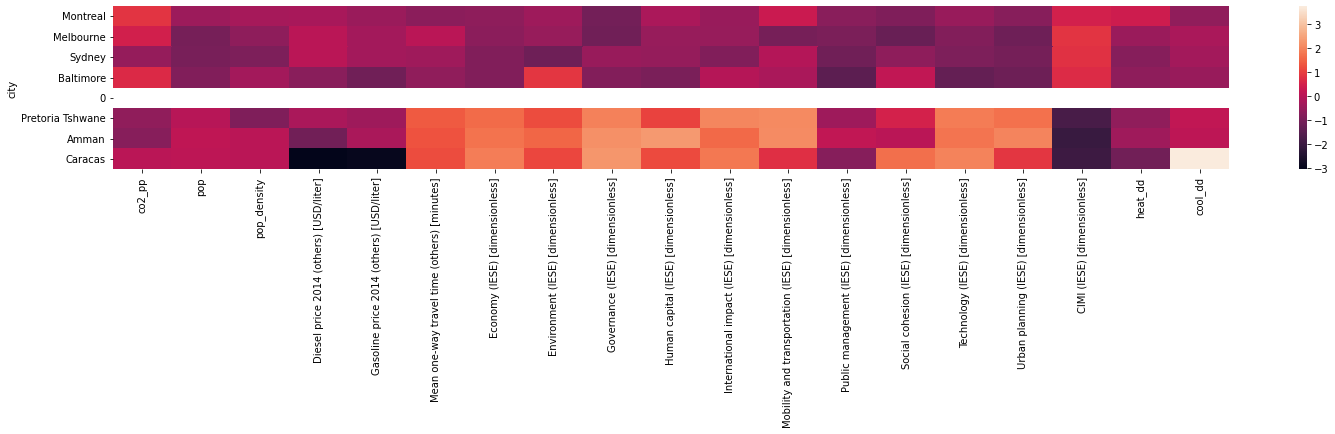

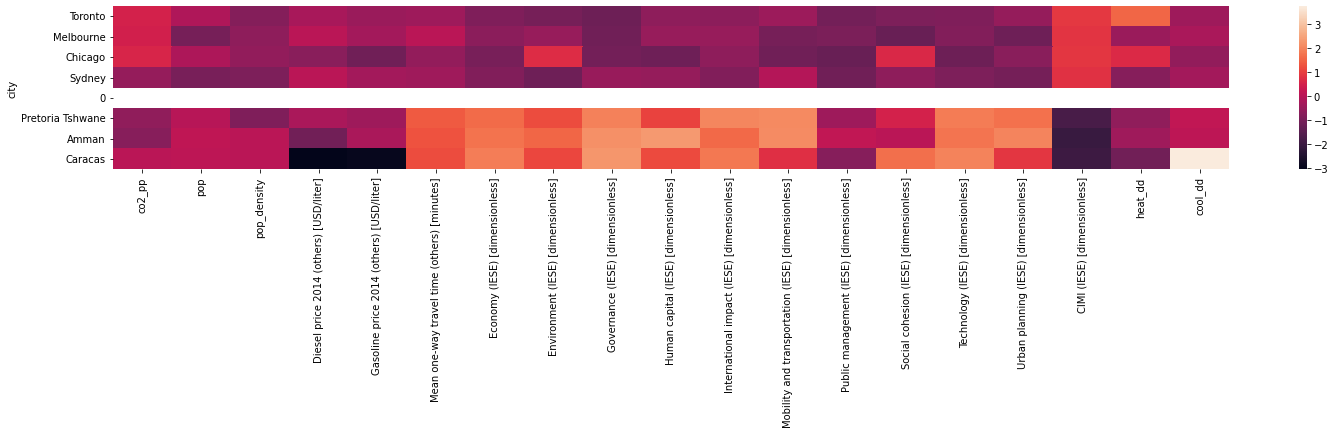

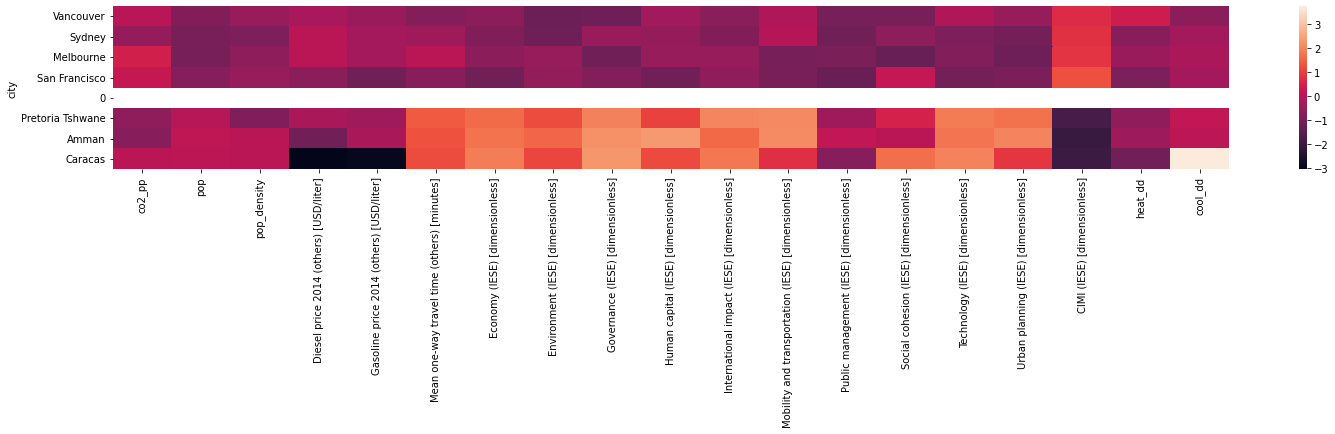

In [279]:
# Heatmaps

# Montreal
city_list = ['Montreal','Melbourne','Sydney','Baltimore',0, 'Pretoria Tshwane' , 'Amman', 'Caracas']
df_ = datA[datA['city'].isin(city_list)].iloc[: , :-1]
df_ = df_.set_index('city') # for seaborn heatmap set city names as indices
df_ = df_.reindex(index = city_list)
fig, ax = plt.subplots(figsize=(25,3)) 
sns.heatmap(df_);

# Montreal
city_list = ['Toronto','Melbourne','Chicago','Sydney',0,'Pretoria Tshwane' , 'Amman', 'Caracas']
df_ = datA[datA['city'].isin(city_list)].iloc[: , :-1]
df_ = df_.set_index('city') # for seaborn heatmap set city names as indices
df_ = df_.reindex(index = city_list)
fig, ax = plt.subplots(figsize=(25,3)) 
sns.heatmap(df_);

# Vancouver
city_list = ['Vancouver','Sydney','Melbourne','San Francisco',0,'Pretoria Tshwane' , 'Amman', 'Caracas']
df_ = datA[datA['city'].isin(city_list)].iloc[: , :-1]
df_ = df_.set_index('city') # for seaborn heatmap set city names as indices
df_ = df_.reindex(index = city_list)
fig, ax = plt.subplots(figsize=(25,3)) 
sns.heatmap(df_);

## MODEL B Repeat KNN with smaller set of least correlated features

 'unsupervised feature selection' is what I want...

Filter low-variance features (an implementation here)
Filter correlated features (can be implemented using corr() from pandas)

### Get pairwise associations

In [295]:
# Make a dataframe with city ID, features, is_cad separately for normalizing and re-using in testing

# First We will use the sub-sets of the data that has coverage of most features: 
id = ['city']
X = ['co2_pp','pop','pop_density','heat_dd','cool_dd','Diesel price 2014 (others) [USD/liter]','Gasoline price 2014 (others) [USD/liter]',
 'Mean one-way travel time (others) [minutes]',
 'Economy (IESE) [dimensionless]',
 'Environment (IESE) [dimensionless]',
 'Governance (IESE) [dimensionless]',
 'Human capital (IESE) [dimensionless]',
 'International impact (IESE) [dimensionless]',
 'Mobility and transportation (IESE) [dimensionless]',
 'Public management (IESE) [dimensionless]',
 'Social cohesion (IESE) [dimensionless]',
 'Technology (IESE) [dimensionless]',
 'Urban planning (IESE) [dimensionless]',
 'CIMI (IESE) [dimensionless]']
cats = ['Region_Africa',
 'Region_East Asia',
 'Region_Europe',
 'Region_Latin America & Caribbean',
 'Region_North Africa, Middle East, West Asia',
 'Region_North America',
 'Region_Oceania',
 'Region_South Asia',
 'Region_Southeast Asia', 
 'is_cad']


# drop NAs (based on these specific cols)
datB = dat04[id+X+cats].dropna(how='any') # Should have 53 cities

print('There are', len(datB), 'cities in this complete dataset, with ', datB.shape[1], 'features.')



# we are going to compute a norm, so first let's scale all the features
datB = datB.assign(**{f: (datB[f] - datB[f].mean())/datB[f].std() for f in X})

#display(datB[X+cats].describe())
# Remove columns with zero values 
cats = ['Region_Africa',
 'Region_East Asia',
 'Region_Europe',
 'Region_Latin America & Caribbean',
 'Region_North Africa, Middle East, West Asia',
 'Region_North America',
 'Region_Oceania',
 #'Region_South Asia',
 #'Region_Southeast Asia', 
 'is_cad']

B_features = datB[X+cats]

There are 53 cities in this complete dataset, with  30 features.


In [296]:
# Linear Correlation table: 

B_features = datB[X+cats]

corrM = B_features.corr()

# Make diagonal for easier reading
mask = np.zeros_like(corrM, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corrM[mask] = np.nan
(corrM
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  from ipykernel import kernelapp as app


,co2_pp,pop,pop_density,heat_dd,cool_dd,Diesel price 2014 (others) [USD/liter],Gasoline price 2014 (others) [USD/liter],Mean one-way travel time (others) [minutes],Economy (IESE) [dimensionless],Environment (IESE) [dimensionless],Governance (IESE) [dimensionless],Human capital (IESE) [dimensionless],International impact (IESE) [dimensionless],Mobility and transportation (IESE) [dimensionless],Public management (IESE) [dimensionless],Social cohesion (IESE) [dimensionless],Technology (IESE) [dimensionless],Urban planning (IESE) [dimensionless],CIMI (IESE) [dimensionless],Region_Africa,Region_East Asia,Region_Europe,Region_Latin America & Caribbean,"Region_North Africa, Middle East, West Asia",Region_North America,Region_Oceania,is_cad
co2_pp,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pop,-0.20,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pop_density,-0.08,0.34,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
heat_dd,0.16,-0.23,-0.18,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
cool_dd,-0.08,0.20,0.10,-0.42,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Diesel price 2014 (others) [USD/liter],0.12,-0.17,-0.12,0.61,-0.47,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Gasoline price 2014 (others) [USD/liter],0.11,-0.09,-0.09,0.47,-0.41,0.92,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Mean one-way travel time (others) [minutes],-0.41,0.59,0.30,-0.34,0.24,-0.22,-0.16,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Economy (IESE) [dimensionless],-0.22,-0.05,0.08,-0.41,0.16,-0.29,-0.14,0.25,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Environment (IESE) [dimensionless],-0.06,0.11,0.30,-0.66,0.32,-0.54,-0.48,0.35,0.47,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [297]:
# What if we drop features with linear correlation stronger than 0.6? [Note: tested all values 0.5, 0.6, 0.7, 0.8]

m = ~(corrM.mask(np.eye(len(corrM), dtype=bool)).abs() > 0.6).any()

reducedSet = corrM.loc[m, m]

(reducedSet
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  # This is added back by InteractiveShellApp.init_path()


,co2_pp,pop,pop_density,cool_dd,Mean one-way travel time (others) [minutes],Social cohesion (IESE) [dimensionless],CIMI (IESE) [dimensionless],Region_Africa,Region_East Asia,Region_Europe,Region_Latin America & Caribbean,"Region_North Africa, Middle East, West Asia",Region_North America,Region_Oceania,is_cad
co2_pp,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pop,-0.20,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pop_density,-0.08,0.34,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
cool_dd,-0.08,0.20,0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Mean one-way travel time (others) [minutes],-0.41,0.59,0.30,0.24,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Social cohesion (IESE) [dimensionless],-0.26,0.47,0.13,0.44,0.45,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CIMI (IESE) [dimensionless],0.19,0.00,-0.02,-0.27,-0.37,-0.45,nan,nan,nan,nan,nan,nan,nan,nan,nan
Region_Africa,-0.11,0.07,-0.19,-0.07,0.21,0.35,-0.44,nan,nan,nan,nan,nan,nan,nan,nan
Region_East Asia,-0.05,0.43,0.56,0.11,0.09,-0.10,0.13,-0.09,nan,nan,nan,nan,nan,nan,nan
Region_Europe,0.12,-0.34,-0.21,-0.26,-0.29,-0.51,0.25,-0.19,-0.21,nan,nan,nan,nan,nan,nan


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

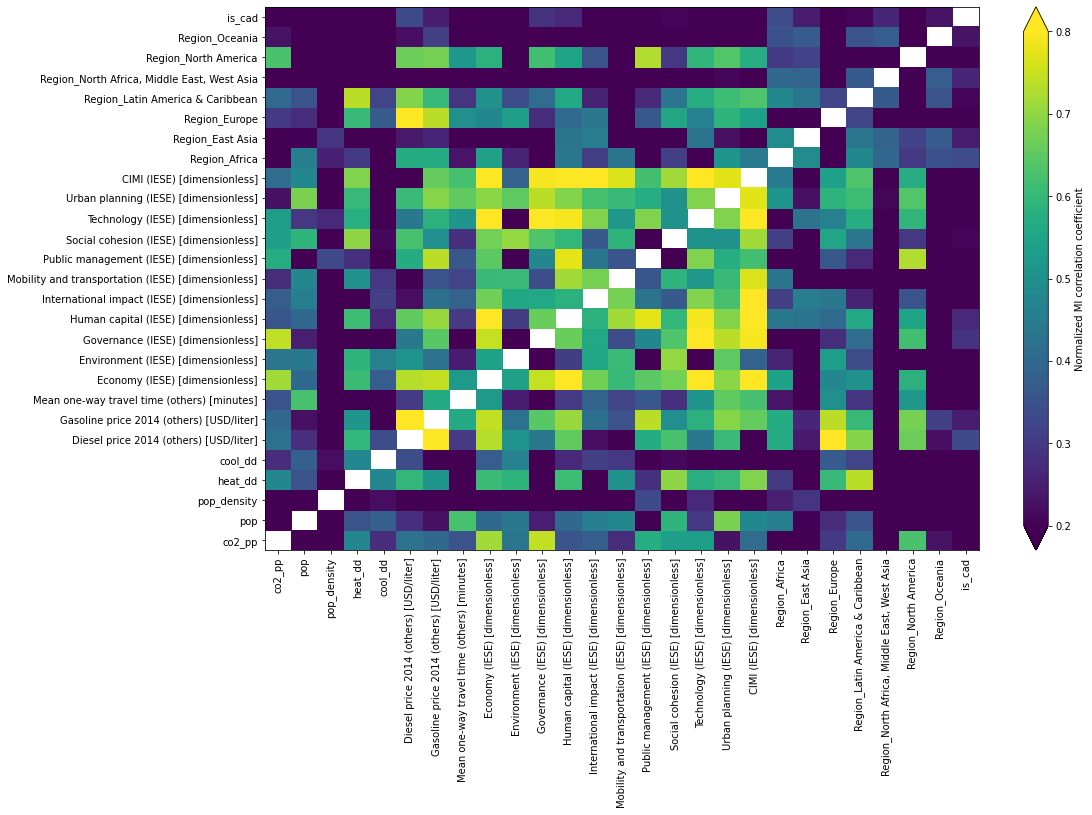

In [298]:
# now try building a correlation table with MI values:

data = B_features
mi_coeffs = pairwise_corr(data)

#sort them before plotting for easier vizualization
#sorted_ = mi_coeffs.mean().sort_values().index
#mi_coeffs_sorted = mi_coeffs[sorted] 

# Plot a matrix where the color represents the correlation coefficient.
# We clip the color values at 0.2 because of significant random noise,
# and at 0.8 to make the color constrast larger.
fig, ax = plt.subplots(figsize=(16,10))
mesh = ax.pcolormesh(mi_coeffs, vmin=0.2, vmax=0.8)
fig.colorbar(mesh, label="Normalized MI correlation coefficient", extend="both")

# Show the variable names on the axes
ax.set_xticks(np.arange(len(data.columns)) + 0.5)
ax.set_yticks(np.arange(len(data.columns)) + 0.5)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.xticks(rotation=90)

plt.savefig("mi_coeffs_original_heatmap.png")
files.download("mi_coeffs_original_heatmap.png")

plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

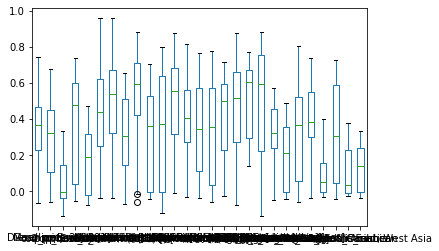

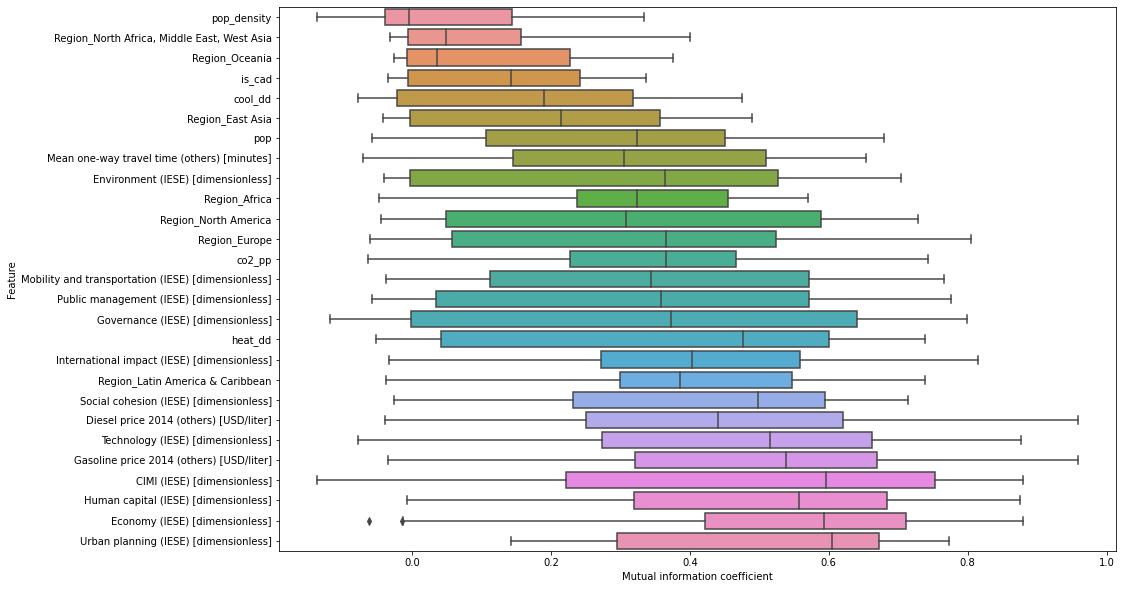

In [299]:

mi_coeffs.boxplot(grid = False)

# Make it more legible:

# Sort them in descending order  
sorted_index = mi_coeffs.mean().sort_values().index
mi_coefffs_sorted = mi_coeffs[sorted_index]

# Then flip to horizontal
df_long = mi_coefffs_sorted.melt(var_name='Feature',value_name='Mutual information coefficient')


fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns_plot = sns.boxplot(y = 'Feature',
            x = 'Mutual information coefficient',
            data = df_long,
            ax=ax)


sns_plot.figure.savefig("mi_coeffs_boxplot.png")
files.download("mi_coeffs_boxplot.png")

Dropping Diesel price 2014 (others) [USD/liter]
Dropping Economy (IESE) [dimensionless]
Dropping CIMI (IESE) [dimensionless]


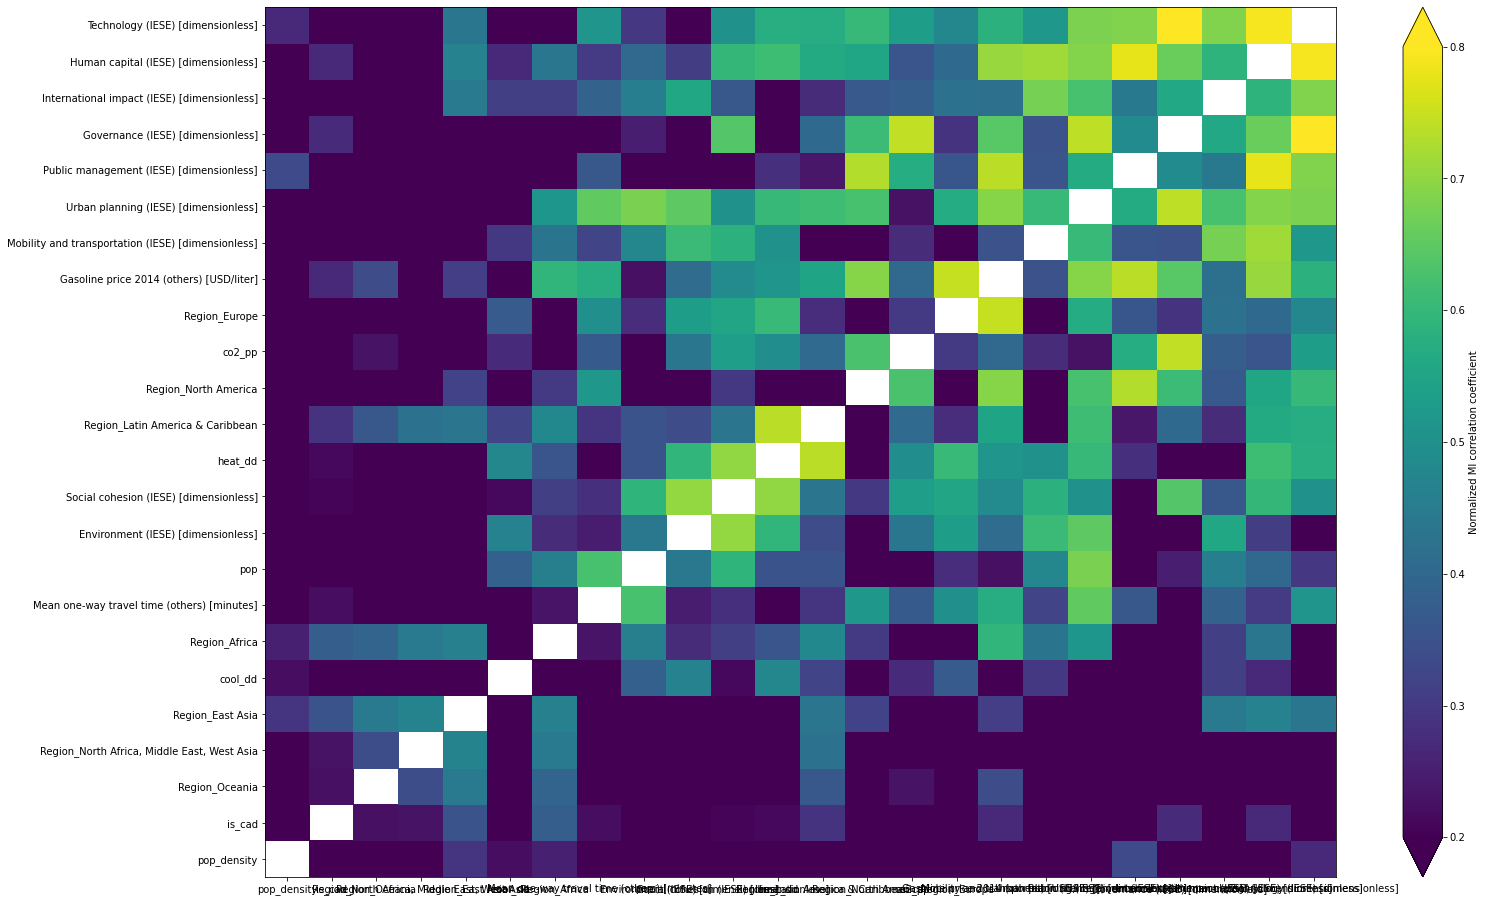

In [300]:
# Now, what if we drop some? 
#Note: dropping one at a time! Because the absence of one impacts the MI scores of all the others...]
# Strategy: sort by 'max' and drop highest, one at a time...recalculate between each step.


#DROP DIESEL PRICE
sorted_max = mi_coeffs.max().sort_values().index
print('Dropping',sorted_max[-1])
cols_keep = sorted_max[:-1] 
# redo table dropping the highest:
data = B_features[cols_keep]
mi_coeffs = pairwise_corr(data)


# DROPPING CIMI
sorted_max = mi_coeffs.max().sort_values().index
print('Dropping',sorted_max[-1])
cols_keep = sorted_max[:-1] 
# redo table dropping the highest:
data = B_features[cols_keep]
mi_coeffs = pairwise_corr(data)


# DROPPING ECONOMY:   
sorted_max = mi_coeffs.max().sort_values().index
print('Dropping',sorted_max[-1])
cols_keep = sorted_max[:-1] 
# redo table dropping the highest:
data = B_features[cols_keep]
mi_coeffs = pairwise_corr(data)

 
fig, ax = plt.subplots(figsize=(24,16))
mesh = ax.pcolormesh(mi_coeffs, vmin=0.2, vmax=0.8)
fig.colorbar(mesh, label="Normalized MI correlation coefficient", extend="both")

# Show the variable names on the axes
ax.set_xticks(np.arange(len(data.columns)) + 0.5)
ax.set_yticks(np.arange(len(data.columns)) + 0.5)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)

plt.show() 

B_feat_re = data.copy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

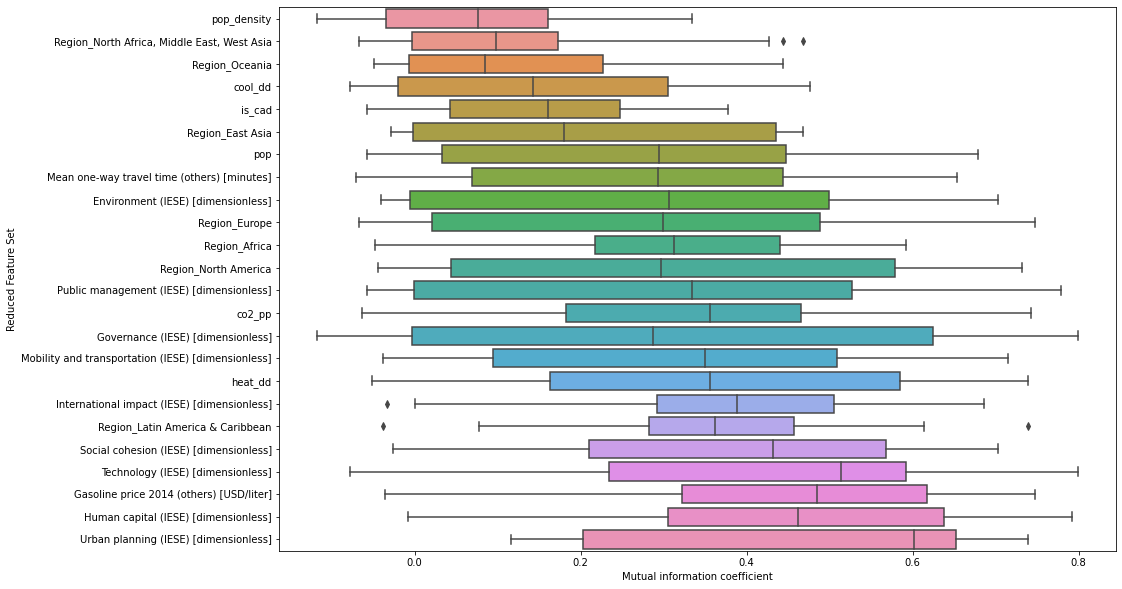

In [301]:
# What do the MI spreads look like now?

# Sort them in descending order  
sorted_index = mi_coeffs.mean().sort_values().index
mi_coefffs_sorted = mi_coeffs[sorted_index]

# Then flip to horizontal
df_long = mi_coefffs_sorted.melt(var_name='Reduced Feature Set',value_name='Mutual information coefficient')

fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns_plot = sns.boxplot(y = 'Reduced Feature Set',
            x = 'Mutual information coefficient',
            data = df_long,
            ax=ax)


sns_plot.figure.savefig("mi_coeffs_reduced_boxplot.png")
files.download("mi_coeffs_reduced_boxplot.png")


Check KNN with reduced features:

In [ ]:
datB_re = datB[id+ B_feat_re.columns.to_list()]
print('There are', len(datB_re), 'cities in this complete dataset, with ', datB_re.shape[1], 'features.')

There are 53 cities in this complete dataset, with  25 features.


### K-nearest neighbours

In [ ]:
# Repeat the NN exercise above... 

# the 'test' set are the Canadian cities
X_train = (datB_re.query('is_cad == 0').iloc[ :, 1:]).to_numpy()# The data matrix, without CAD cities
y_train = datB_re.query('is_cad==0').iloc[:,0].to_numpy() # The class labels, of non-CAD cities

X_CAD = (datB_re.query('is_cad == 1').iloc[ :, 1:]).to_numpy()
y_CAD = datB_re.query('is_cad==1').iloc[:,0].to_numpy()

In [ ]:
# Calculate the norms
def calc_distances():
  for c in range(3):
    city = X_CAD[c]

    distances = []
    for i, row in enumerate(X_train):
        distance = euclidean_distance(city, row)
        distances.append((i, distance))
    distances.sort(key=lambda tup: tup[1])

    k = 3 # Number of nearest neighbors
    print('\nTop %d Nearest Neighbors:' % k)
    for nn in range(k):
        print(X_train[distances[nn][0]], y_train[distances[nn][0]])

    print('The city of',y_CAD[c], 'is most similar to', y_train[distances[0][0]], ',' ,y_train[distances[1][0]], 'and', y_train[distances[2][0]],'.')
    print('The city of',y_CAD[c], 'is least similar to', y_train[distances[-3][0]], ',' ,y_train[distances[-2][0]], 'and', y_train[distances[-1][0]],'.')
    
calc_distances()


Top 3 Nearest Neighbors:
[-0.63032176  0.          1.          0.          0.         -0.21106078
  0.          0.05509743 -0.98601818 -0.50067523 -0.50172687 -1.22218291
 -0.98937033  0.          0.         -0.43001445 -1.11339858  0.46308919
  0.         -0.29615353 -0.92126656 -1.09897417 -0.80068722 -0.49559882] Melbourne
[-0.30028263  0.          0.          0.          0.         -0.46568259
  0.         -0.59175601 -0.83018061 -0.01489423  0.87882351  0.18205946
 -0.18836373  1.          0.         -0.63348698 -1.1538858   0.67502566
  0.         -1.09775057 -1.42698513 -0.82104683 -1.28249814 -0.95097173] Baltimore
[ 0.21830223  0.          0.          0.          0.         -0.56116577
  0.         -0.71031419 -0.81993819 -0.1160986   0.77262733 -0.25927386
 -1.1847378   1.          0.          0.67849657 -0.87047525  0.43354972
  0.         -1.09775057 -1.30055549 -1.07912222 -1.02306149 -1.24075449] Boston
The city of Montreal is most similar to Melbourne , Baltimore and Bo

### Vizualize results of KNN on reduced features

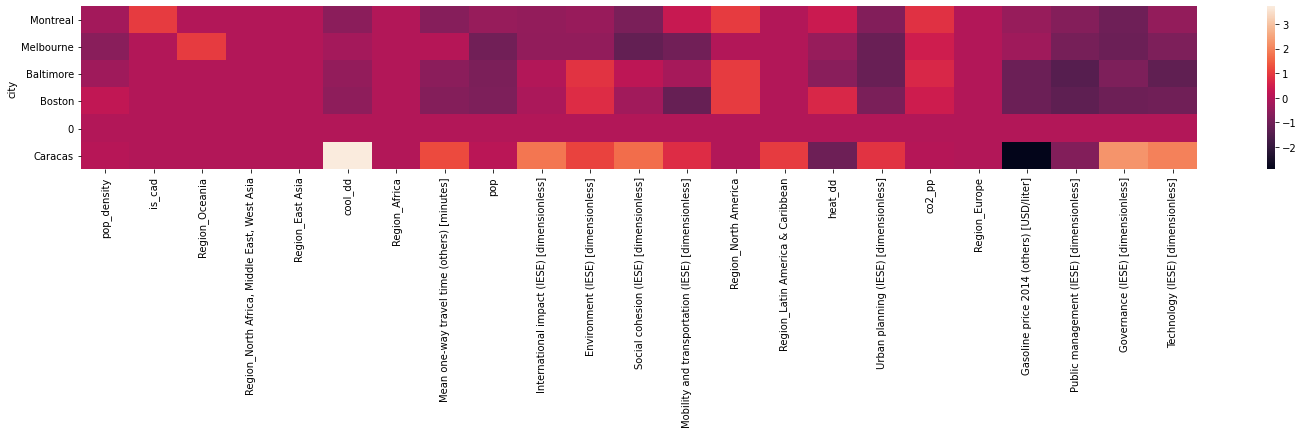

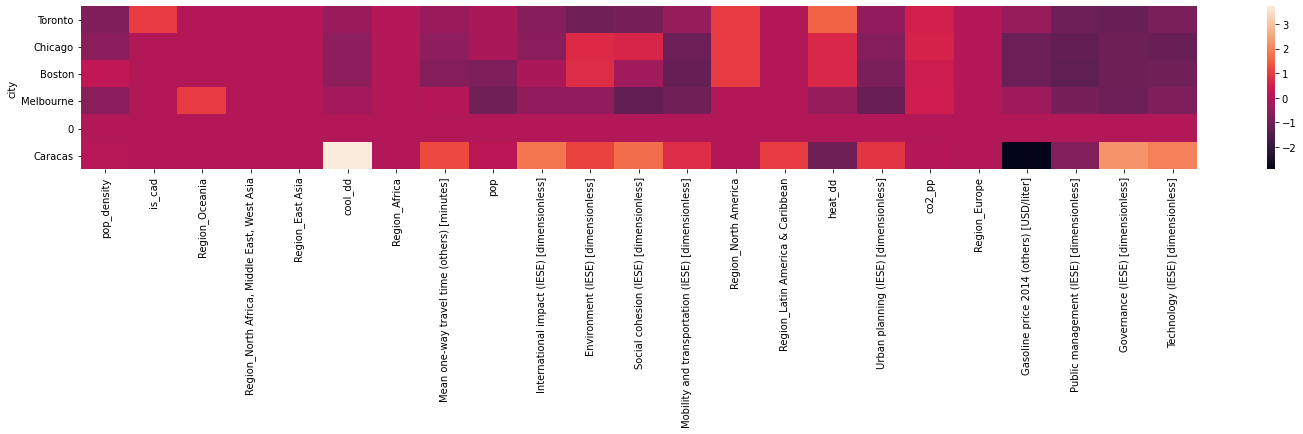

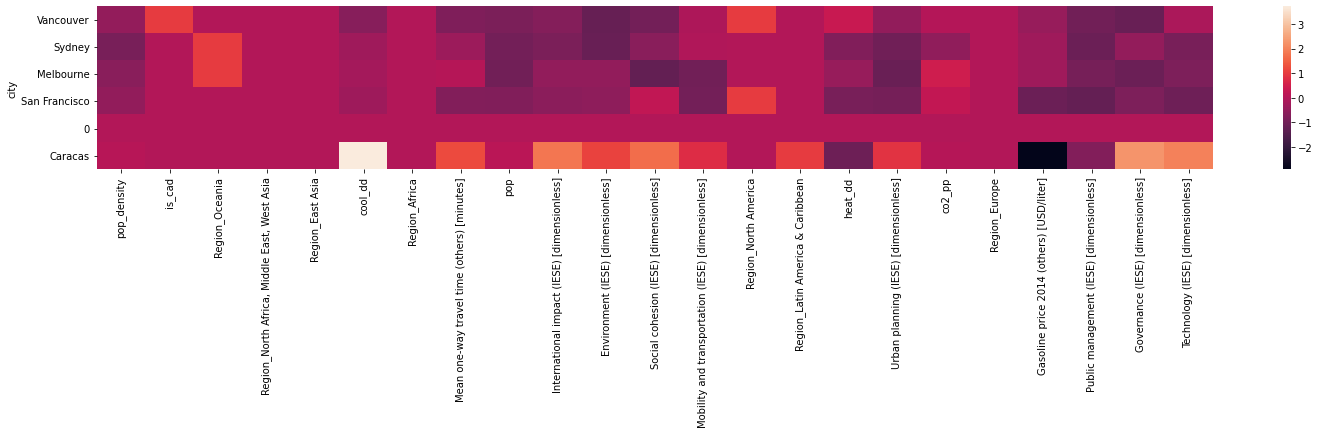

In [ ]:
# Just for plotting purposes, create a 'mean' city with values 0
datB_viz = datB_re.copy()
datB_viz.loc[len(datB_viz)] = 0


# Plot Heatmaps

# Montreal
city_list = ['Montreal','Melbourne','Baltimore','Boston',0,'Caracas'] 
df_ = datB_viz[datB_viz['city'].isin(city_list)].iloc[: , :-1]
df_ = df_.set_index('city') # for seaborn heatmap set city names as indices
df_ = df_.reindex(index = city_list)
fig, ax = plt.subplots(figsize=(25,3)) 
sns.heatmap(df_);

# Toronto
city_list = ['Toronto','Chicago','Boston','Melbourne',0,'Caracas']
df_ = datB_viz[datB_viz['city'].isin(city_list)].iloc[: , :-1]
df_ = df_.set_index('city') # for seaborn heatmap set city names as indices
df_ = df_.reindex(index = city_list)
fig, ax = plt.subplots(figsize=(25,3)) 
sns.heatmap(df_);

# Vancouver
city_list = ['Vancouver','Sydney','Melbourne','San Francisco',0,'Caracas']
df_ = datB_viz[datB_viz['city'].isin(city_list)].iloc[: , :-1]
df_ = df_.set_index('city') # for seaborn heatmap set city names as indices
df_ = df_.reindex(index = city_list)
fig, ax = plt.subplots(figsize=(25,3)) 
sns.heatmap(df_);

# Archives

In [ ]:
# Use Random Forest for feature selection from larger set of features

datB_features = datB.iloc[:,1:]
model = RandomForestRegressor(random_state=1, max_depth=10)


There are 30 cities in this complete dataset, with  30 features.


In [ ]:


print('The new reduced set produces the following MI matrix.')
m = ~(mi_coeffs.mask(np.eye(len(mi_coeffs), dtype=bool)).abs() > thresh).any()
reducedSet_mi = mi_coeffs.loc[m, m].columns.to_list()
data = B_features[reducedSet_mi]
mi_coeffs_re = pairwise_corr(data)

# Plot a matrix where the color represents the correlation coefficient.
# We clip the color values at 0.2 because of significant random noise,
# and at 0.8 to make the color constrast larger.
fig, ax = plt.subplots(figsize=(24,16))
mesh = ax.pcolormesh(mi_coeffs_re, vmin=0.2, vmax=0.8)
fig.colorbar(mesh, label="Normalized MI correlation coefficient", extend="both")

# Show the variable names on the axes
ax.set_xticks(np.arange(len(data.columns)) + 0.5)
ax.set_yticks(np.arange(len(data.columns)) + 0.5)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)

plt.show()

In [ ]:
cols_keep_short = ['city', 
        #'Reporting year (CDP)', 
        'co2_tot', #'Scope-1 GHG emissions units', 'Year of emission', 'Gases included (CDP)', 'Increase/Decrease from last year (CDP)', 'Scope-2 (CDP) [tCO2-eq]', 'Total emissions (CDP) [tCO2-eq]', 'S1 lower bound [tCO2] (CDP)', 'S1 upper bound [tCO2] (CDP)', 'S1 mean (CDP) [tCO2]', 'TOT lower bound [tCO2] (CDP)', 'TOT upper bound [tCO2] (CDP)', 'TOT mean (CDP) [tCO2]', 'CO2 emissions per capita (PKU) [tCO2/capita]', 'City location (CDP) [degrees]', 'Latitude (others) [degrees]', 'Longitude (others) [degrees]', 
        'Country', 
        'Region', #'Population (CDP)', 'Population year (CDP)', 'Population (carbonn)', 'Population year (carbonn)', 'Urban population (PKU)', 'Population (GEA)', 'Population (UITP)', 'Population (WB)', 'Population growth rate 1950-2010 (WB) [people/60years]', 'Population growth rate 1990-2010 (WB) [people/20years]', 'City area (CDP) [km2]', 'City area (GEA) [km2]', 'City area (WB) [km2]', 'Built-up area (PKU) [km2]', 'City area (others) [km2]', 'Population density (GEA) [people/km2]', 'Population density (UITP) [people/km2]', 'Population density (WB) [people/km2]', 'Population/sqrt(area) (GEA) [people/km]', 'Population/sqrt(area) (WB) [people/km]', 'Average altitude [m]', 
         #'Average annual temperature (CDP) [degrees Celsius]', 'Weather station ID (GEA+)', 'CDD 23C (GEA+) [degrees C × days]', 'HDD 15.5C (GEA+) [degrees C × days]', 'HDD 15.5C (clim) [degrees C × days]', 'CDD 23C (clim) [degrees C × days]', #'GDP (CDP) [multiple units]', 'GDP unit (CDP)', 'GDP (carbonn) [multiple units]', 'nGDP (carbonn) [multiple units]', 'GDP unit (carbonn)', 'GDP (PKU) [10000 RMB]', 'Income per capita (PKU) [RMB/capita]', 'GDP-PPP (others) [$BN]', 'GDP-PPP/capita (others) [USD/capita]', 'GDP-PPP year (others)', 'nGDP (others) [$BN]', 'nGDP/capita (others) [USD/capita]', 'nGDP year (others)', 'GDP-PPP/capita (GEA) [USD/year]', 'GDP-PPP/capita (UITP) [USD/year]', 'GDP-PPP/capita (WB) [USD/year]', 'nrg_pp', 'Energy per capita CO2 (WB) [tCO2-eq/capita/yr]', 
        #'Diesel price (GEA+) [USD/liter]', 
        'Gasoline price (GEA+) [USD/liter]', #'Diesel price 2014 (others) [USD/liter]', 'Gasoline price 2014 (others) [USD/liter]', 'Center of commerce index (GEA+) [dimensionless]', 'Household size (GEA+) [people/household]', 'Household size (others) [people/household]', 'Urbanization ratio (GEA+) [percent]', 'Water bounded (GEA+)', 'Other bounded (GEA+)', 'Mean one-way travel time (others) [minutes]', 
        'Congestion rank (INRIX) [dimensionless]', #'Peak hours spent in congestion (INRIX) [hours]', 'INRIX congestion index (INRIX) [dimensionless]', 'Average congestion rate (INRIX) [percent]', 'Congestion rank (TomTom) [dimensionless]', 'Congestion level (TomTom) [× 100 percent]', 'Congestion change (TomTom) [× 100 percent]', 'Morning peak (TomTom) [percent]', 'Evening peak (TomTom) [percent]', 
        'Economy (IESE) [dimensionless]', 
        'Environment (IESE) [dimensionless]', 
        'Governance (IESE) [dimensionless]', 
        'Human capital (IESE) [dimensionless]', 
        'International impact (IESE) [dimensionless]', 
        'Mobility and transportation (IESE) [dimensionless]', 
        'Public management (IESE) [dimensionless]', 
        'Social cohesion (IESE) [dimensionless]', 
        'Technology (IESE) [dimensionless]', 
        'Urban planning (IESE) [dimensionless]', 
        'CIMI (IESE) [dimensionless]', 'CIMI ranking (IESE) [dimensionless]', 'CIMI performance (IESE) [dimensionless]', 
        #'Urban area name (UEX)', 'Low BUA - 1990 (UEX) [km2]', 'Low BUA - 2000 (UEX) [km2]', 'Low BUA - 2014 (UEX) [km2]', 'High BUA - 1990 (UEX) [km2]', 'High BUA - 2000 (UEX) [km2]', 'High BUA - 2014 (UEX) [km2]', 'Low BUA % - 1990 (UEX) [percent]', 'Low BUA % - 2000 (UEX) [percent]', 'Low BUA % - 2014 (UEX) [percent]', 'High BUA % - 1990 (UEX) [percent]', 'High BUA % - 2000 (UEX) [percent]', 'High BUA % - 2014 (UEX) [percent]', 'Low BUA population density - 1990 (UEX) [people/km2]', 'High BUA population density - 1990 (UEX) [people/km2]', 'Low BUA population density - 2000 (UEX) [people/km2]', 'High BUA population density - 2000 (UEX) [people/km2]', 'Low BUA population density - 2014 (UEX) [people/km2]', 'High BUA population density - 2014 (UEX) [people/km2]', 'Exports (others) [m3]', 'Production (others) [m3]', 'Natgas Export/Production ratio (others)', 'CH4_waste/capita (others) [tCH4/capita]', 'CH4_waste+natgas/capita (others) [tCH4/capita]', 'Corrected CH4_(waste+natgas)/capita (others) [tCH4/capita]', 
        'is_cad', 
        'heat_dd', 'cool_dd', #'pop', 'area', 
        'pop_density']

# Convert remaining strings to categorical (except City Names)



